#imports

In [1]:
import numpy as np
%matplotlib inline
import os,random
import keras.models as models
import matplotlib.pyplot as plt
import _pickle as cPickle
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import LabelBinarizer as LB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,Reshape,Dropout,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from keras import metrics
from pandas import DataFrame as df
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Get Data

In [ ]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!mv 'RML2016.10b.tar.bz2' '../content/drive/MyDrive/DM_4/Data/'
!bunzip2 '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar.bz2' 

#load data

In [ ]:
!tar -xf '../content/drive/MyDrive/DM_4/Data/RML2016.10b.tar'
!mv 'RML2016.10b.dat' '../content/drive/MyDrive/DM_4/Data/'
!mv 'LICENSE.TXT' '../content/drive/MyDrive/DM_4/Data/'

In [2]:
# Load the dataset
file = open("../content/drive/MyDrive/DM_4/Data/RML2016.10b.dat",'rb')
Xd = cPickle.load(file, encoding = 'latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()


In [ ]:
print(X.shape)
X.shape[1:]

(1200000, 2, 128)


(2, 128)

In [3]:
#input shape is (2, 128)
in_shp = list(X.shape[1:])

# num exist classes
classes = mods
print(mods, len(mods))

#first feature
print( X[:,0].shape)
#second feature
print( X[:,1].shape)

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] 10
(1200000, 128)
(1200000, 128)


#Create Features Space

In [4]:
features = {}

#Raw Time Feature
features['raw'] = X[:,0], X[:,1]

#First derivative in time
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

#Integral in time
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

#combinations of 1,2 and 3
def extract_features(*arguments):
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    return np.stack(desired, axis = 1)

#Split data into training/validation and testing
    ○ Split the data into 70% for training/validation and 30% for testing.
    ○ Use 5% of the training and validation dataset for validation.


In [5]:
#choose features
#data = extract_features('raw','integral')
data = extract_features('raw')
labels = np.array(lbl)
print("data shape ", data.shape)
print("labels shape ", labels.shape)
print("data ", data)
print("labels ", labels)

#data shuffling & splitting
np.random.seed(10)
n_examples = labels.shape[0]
r = np.random.choice(range(n_examples), n_examples, replace = False)

num_training = n_examples*0.7
train_examples = r[:int(num_training)]
test_examples =  r[int(num_training):]
print("train_examples ", len(train_examples))
print("test_examples ", len(test_examples))

X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


data shape  (1200000, 2, 128)
labels shape  (1200000, 2)
data  [[[ 0.00907056  0.00599482 -0.0035653  ... -0.00235585 -0.0008447
    0.00397915]
  [-0.0005109   0.00754676  0.00611815 ... -0.00607358 -0.0072575
   -0.00728448]]

 [[-0.00419709 -0.01053281 -0.00680017 ... -0.00901077 -0.00263061
   -0.00519594]
  [ 0.0089433  -0.00966051  0.00101369 ...  0.00162549 -0.00118617
    0.005617  ]]

 [[ 0.00174664 -0.0084256   0.00147178 ... -0.00643154  0.00503035
    0.02152551]
  [-0.00100279 -0.00339724 -0.00072322 ...  0.00198796 -0.00023271
    0.00323295]]

 ...

 [[ 0.0027236   0.00265014  0.00258855 ...  0.00280217  0.00278396
    0.00279103]
  [-0.00729888 -0.00731881 -0.00735847 ... -0.00736364 -0.00733167
   -0.00727415]]

 [[ 0.00396798  0.00391821  0.00399417 ...  0.00398769  0.00400097
    0.00397493]
  [-0.0067528  -0.00674574 -0.00678544 ... -0.00657877 -0.00664485
   -0.00665402]]

 [[ 0.00492854  0.00492476  0.00497359 ...  0.00499452  0.00501002
    0.00498357]
  [-0.0060

#Model fully connected dense layer

In [ ]:
def full_connected_model(in_shape):
  # Declare layers size
  hidden1_size = 512
  hidden2_size = 256
  hidden3_size = 10

  # Build model
  model = Sequential()
  model.add(Dense(hidden1_size, input_shape = in_shape, activation ='relu'))
  model.add(Dense(hidden2_size, activation ='relu'))
  model.add(Flatten())
  model.add(Dense(hidden3_size, activation ='softmax'))

  # Compile model
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
  model.summary()
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_5 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
390/390 [==============================] - 3s 6ms/step - loss: 2.0293 - accuracy: 0.2249 - val_loss: 1.6911 - val_accuracy: 0.3329

Epoch 00001: val_accuracy improved from -inf to 0.33293, saving model to ../content/drive/MyDrive/DM_4

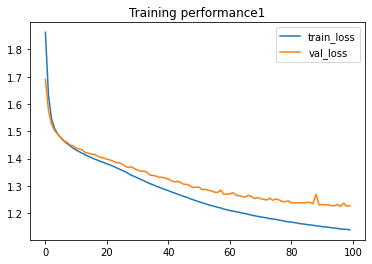

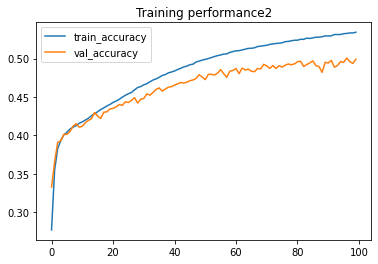

In [ ]:
def train_full_connected_model(X_train, y_train, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  # this is both on training and validation data, hence two curves. They track well.
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_full_connected_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_raw2.h5', 100)


#Test of fully connected

In [ ]:
def test_full_connected_model(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_full_connected_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_raw2.h5', 100)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_10 (Dense)             (None, 2, 256)            131328    
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[1.2350635528564453, 0.4950805604457855]


#Plots of the accuracy against the SNR 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_10 (Dense)             (None, 2, 256)            131328    
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


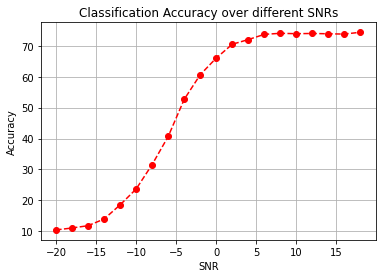

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_raw2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_raw2.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = full_connected_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/fully_connected_raw2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/fully_connected_raw2.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2, 512)            66048     
_________________________________________________________________
dense_13 (Dense)             (None, 2, 256)            131328    
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.46,11.08,11.83,13.98,18.56,23.69,31.6,40.67,52.67,60.64,66.04,70.49,72.01,73.7,74.04,73.91,73.99,73.88,73.79,74.38


#confusion matrices and find the most confusing classes

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
[[3.87632775e-01 3.67448214e-02 1.12548440e-01 8.06546043e-02
  5.42529761e-02 2.47009953e-02 1.02037972e-01 3.25629374e-02
  1.51189049e-01 1.76754300e-02]
 [3.93967119e-02 7.18816712e-01 5.29817849e-02 2.10984502e-02
  3.88144944e-02 9.56500042

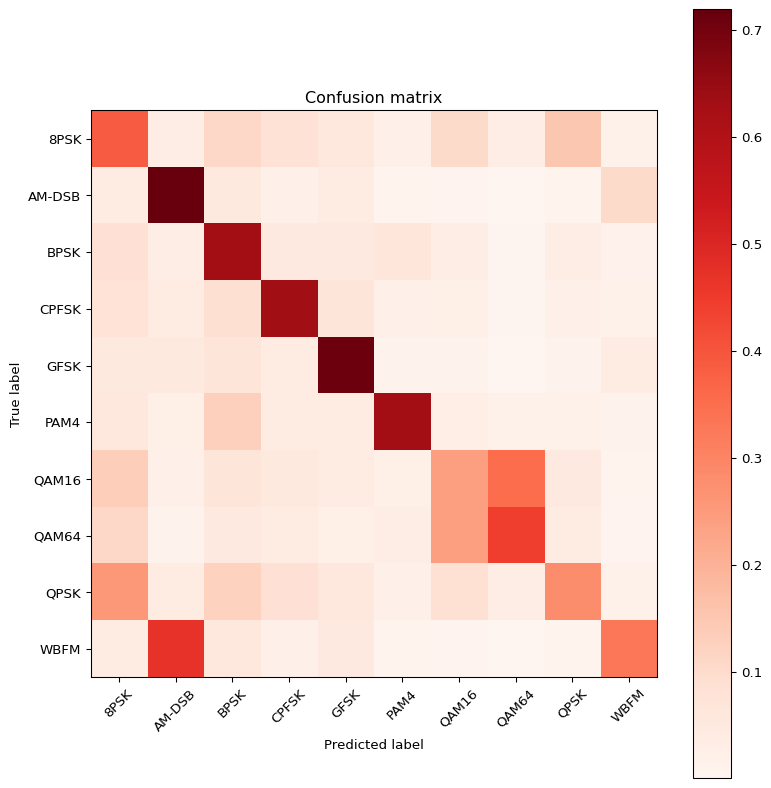

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = full_connected_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/fully_connected_raw2.h5', 100)


#Model CNN

In [ ]:
def cnn_model(in_shape):
  conv1_kernel_shape=(3,1)
  conv1_number_of_filters=64
  conv2_kernel_shape=(3,2)
  conv2_number_of_filters=16
  dense1_size = 128
  dense2_size = 10
  dropout = 0.4

  # Build model
  model_conv = Sequential()
  model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
  model_conv.add(Conv2D(conv1_number_of_filters, conv1_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(BatchNormalization())
  model_conv.add(MaxPooling2D())
  model_conv.add(Conv2D(conv2_number_of_filters, conv2_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu'))
  model_conv.add(Flatten())
  model_conv.add(Dropout(rate=1-dropout))
  model_conv.add(Dense(dense1_size, activation='relu'))
  model_conv.add(Dense(dense2_size, activation='softmax'))

  # Compile model
  model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_conv.summary()
  return model_conv

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)             

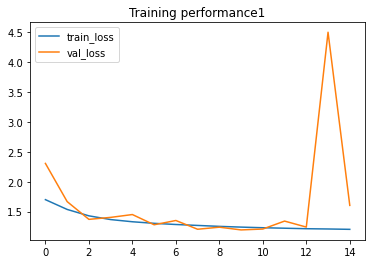

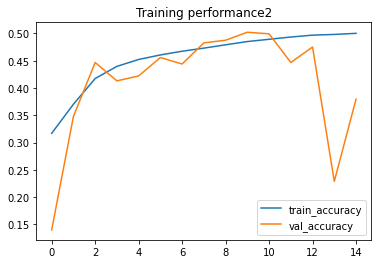

In [ ]:
def train_cnn_model(X_train, y_train, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  train_history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.05, batch_size = 2048, callbacks=[es,mc])

  # Show loss curves
  plt.figure()
  plt.title('Training performance1')
  plt.plot(train_history.epoch, train_history.history['loss'], label='train_loss')
  plt.plot(train_history.epoch, train_history.history['val_loss'], label='val_loss')
  plt.legend()

  # Show accuracy curves
  plt.figure()
  plt.title('Training performance2')
  plt.plot(train_history.epoch, train_history.history['accuracy'], label='train_accuracy')
  plt.plot(train_history.epoch, train_history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

train_cnn_model(X_train, y_train, (2,128), '../content/drive/MyDrive/DM_4/CNN_raw.h5', 100)


#Test of CNN

In [ ]:
def test_cnn_model(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  score = model.evaluate(X_test, y_test, verbose=0, batch_size=2048)
  print(score)

test_cnn_model(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_raw.h5', 100)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

#Plots of the accuracy against the SNR 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

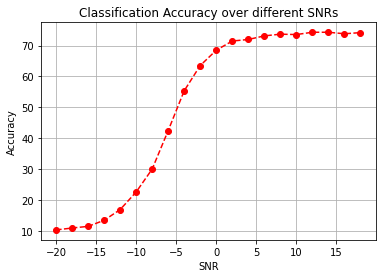

In [ ]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_raw.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_raw.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

plot_results(y_pred_FC, y_test, snr_test)

#Report the average overall accuracy as well as the results at SNR=0dB

In [ ]:
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

model = cnn_model((2,128))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('../content/drive/MyDrive/DM_4/CNN_raw.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.load_weights('../content/drive/MyDrive/DM_4/CNN_raw.h5')
y_pred_FC = model.predict(X_test, batch_size=batch_size)

print_results(y_pred_FC, y_test, snr_test)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.43,11.04,11.58,13.54,16.99,22.67,30.08,42.52,55.37,63.53,68.48,71.45,71.95,73.1,73.66,73.54,74.28,74.29,73.79,74.17


#confusion matrices and find the most confusing classes

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 2, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 1, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 1, 16)         6160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

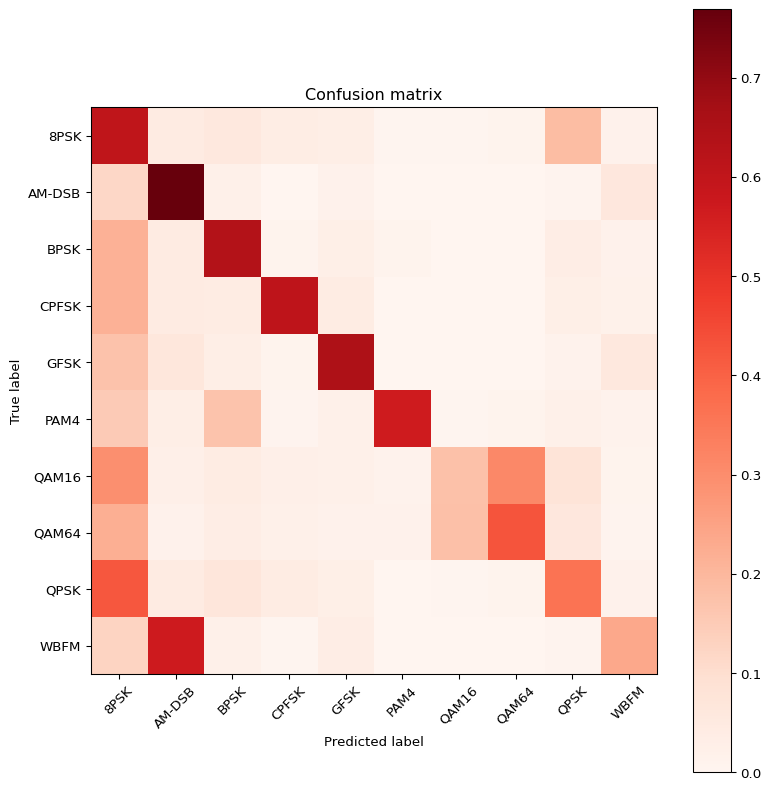

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
batch_size = 1024  # training batch size
# Plot confusion matrix
def Plot_confusion(X_test, y_test, input_shape, filename, epochs):
  model = cnn_model(input_shape)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  model.load_weights(filename)
  # Show simple version of performance
  test_Y_hat = model.predict(X_test, batch_size=batch_size)
  #fill matrices with zeros
  conf = np.zeros([len(classes),len(classes)])
  #normalize confusion matrix
  confnorm = np.zeros([len(classes),len(classes)])
 
  #this puts all the data into an 11 x 11 matrix for plotting.
  for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
  #takes the data to plot and normalizes it
  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  print (confnorm)
  print (classes)
  plot_confusion_matrix(confnorm, labels=classes)

Plot_confusion(X_test, y_test, (2,128), '../content/drive/MyDrive/DM_4/CNN_raw.h5', 100)


#Model Logistic Regression Classifier

In [6]:
y_train_convert = []
for y in y_train:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_train_convert.append(index_of_maximum)

y_test_convert = []
for y in y_test:
  maximum = np.max(y)
  index_of_maximum = np.where(y == maximum)
  y_test_convert.append(index_of_maximum)

In [7]:
from sklearn.linear_model import LogisticRegression
print(X_train.shape)
print(snr_train.shape)
# Create an instance of the scaler and apply it to the data
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

y_train_convert = np.squeeze(y_train_convert) 
y_test_convert = np.squeeze(y_test_convert)
print(y_train_convert.shape)
print(y_test_convert.shape)

LogReg_clf = LogisticRegression()
lrcModel = LogReg_clf.fit(d2_train_dataset, y_train_convert)


y_pred_lrcModel = lrcModel.predict(d2_test_dataset)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_convert, y_pred_lrcModel))
print(confusion_matrix(y_test_convert, y_pred_lrcModel))
print(metrics.classification_report(y_test_convert, y_pred_lrcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

(840000, 2, 128)
(840000,)
(840000,)
(360000,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.16115
[[ 4709  1314  4129  5070  3041  3828  4071  3711  3420  2576]
 [ 1619 16331  1379  1597  1634  1250  1071  1852  1706  7630]
 [ 4490  1227  3943  4997  3079  3903  4112  3980  3513  2658]
 [ 4805  1863  3701  5195  3208  3467  3586  3640  3302  3106]
 [ 4365  4145  2692  4502  4253  2126  2391  3910  3267  4600]
 [ 3999  1968  3622  4523  3066  3667  4091  3946  3331  3787]
 [ 4623  1714  3988  5080  2903  3712  4099  3826  2960  3258]
 [ 4399  1993  3791  5100  2679  3649  4090  3910  2773  3497]
 [ 4691  1293  4044  5115  3111  3866  4104  3681  3430  2578]
 [ 1754 14264  1464  1911  2050  1373  1068  1771  1947  8477]]
              precision    recall  f1-score   support

        8PSK       0.12      0.13      0.13     35869
      AM-DSB       0.35      0.45      0.40     36069
        BPSK       0.12      0.11      0.11     35902
       CPFSK       0.12      0.14      0.13     35873
        GFSK       0.15      0.12      0.13     36251
        PAM4       0.12   

In [8]:
rows, cols = (360000, 10)
y_pred_lrcModel_convert = [[0 for i in range(cols)] for j in range(rows)] 
for i in range(360000):
  y_pred_lrcModel_convert[i][y_pred_lrcModel[i]] = 1

In [9]:
print(y_pred_lrcModel_convert[0:5])
print(y_pred_lrcModel_convert[0][0])
print(y_pred_lrcModel[0:5])
y_pred_lrcModel_convert = np.array(y_pred_lrcModel_convert)
print(y_pred_lrcModel_convert.shape)

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
0
[5 1 0 3 5]
(360000, 10)


#Evaluation

In [10]:
def plot_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)
batch_size = 1024
def print_results(predicted_labels, true_labels, snrs):
  sorted_snrs = np.sort(np.unique(snrs))
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.13128328 0.0366333  0.11511333 0.14134768 0.08478073 0.10672168
  0.11349633 0.10345981 0.09534696 0.07181689]
 [0.04488619 0.45277108 0.03823228 0.04427625 0.04530206 0.0346558
  0.02969309 0.05134603 0.04729823 0.21153899]
 [0.12506267 0.03417637 0.10982675 0.13918445 0.08576124 0.10871261
  0.11453401 0.11085733 0.0978497  0.07403487]
 [0.13394475 0.05193321 0.10316951 0.14481644 0.08942659 0.0966465
  0.09996376 0.10146907 0.09204694 0.08658322]
 [0.12041047 0.11434167 0.07426002 0.12418968 0.1173209  0.05864666
  0.0659568  0.10785909 0.09012165 0.12689305]
 [0.11108333 0.05466667 0.10061111 0.12563889 0.08516667 0.10186111
  0.11363889 0.10961111 0.09252778 0.10519444]
 [0.12783785 0.04739651 0.11027846 0.14047507 0.08027542 0.10264635
  0.1133479  0.10579874 0.08185162 0.09009208]
 [0.1225997  0.05554472 0.1056548  0.14213651 0.07466347 0.10169728
  0.1139879  0.10897132 0.07728324 0.09746105]
 [0.13062122 0.03600368 0.11260546 0.14242753 0.08662601 0.10764904
  0.11427617 0

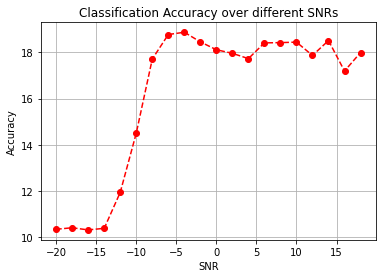

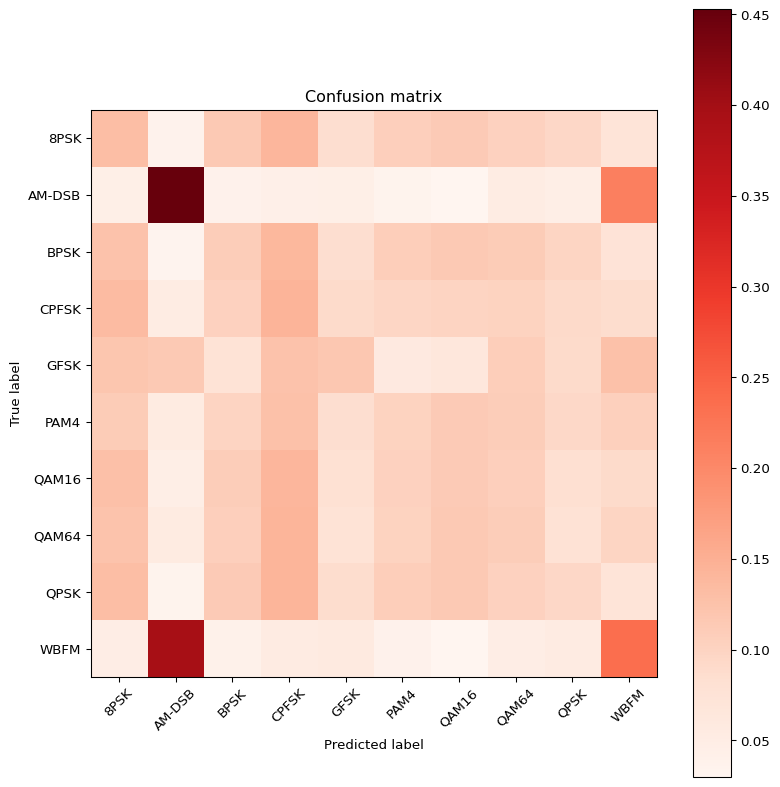

In [11]:
plot_results(y_pred_lrcModel_convert, y_test, snr_test)

conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_lrcModel_convert[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [11]:
print_results(y_pred_lrcModel_convert, y_test, snr_test)


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.34,10.41,10.32,10.39,11.94,14.5,17.71,18.77,18.87,18.45,18.11,17.96,17.73,18.41,18.42,18.44,17.87,18.51,17.19,17.99


#Model Decision Tree 

In [12]:
decisionTreeClassifier = DecisionTreeClassifier()
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))
decisionTreeClassifier.fit(d2_train_dataset, y_train)

nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))
y_pred_dtcModel = decisionTreeClassifier.predict(d2_test_dataset)


In [13]:
# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dtcModel))
print(confusion_matrix(y_test.argmax(axis=1), y_pred_dtcModel.argmax(axis=1)))
print(metrics.classification_report(y_test, y_pred_dtcModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

Accuracy: 0.3105111111111111
[[ 6544  1709  2901  3109  2748  2496  4642  4699  5242  1779]
 [ 1713 13472  1687  1674  2014  1436  1375  1159  1680  9859]
 [ 3068  1647 12817  2346  2099  3496  2765  2589  3346  1729]
 [ 3342  1591  2189 14242  2608  1810  2608  2387  3330  1766]
 [ 2735  1963  2274  2565 15144  1878  2238  1918  2632  2904]
 [ 2475  1414  3621  1971  1903 14296  3222  3300  2400  1398]
 [ 4741  1347  2757  2628  2159  3218  6667  7141  4022  1483]
 [ 4734  1150  2494  2273  1974  3114  7011  8062  3880  1189]
 [ 5288  1657  3408  3311  2604  2255  3930  3757  7961  1742]
 [ 1844  9505  1741  1776  2834  1401  1444  1237  1718 12579]]
              precision    recall  f1-score   support

        8PSK       0.18      0.18      0.18     35869
      AM-DSB       0.38      0.37      0.38     36069
        BPSK       0.36      0.36      0.36     35902
       CPFSK       0.40      0.40      0.40     35873
        GFSK       0.42      0.42      0.42     36251
        PAM4   

#Evaluation

[[0.18244166 0.0476456  0.08087764 0.08667652 0.07661212 0.06958655
  0.12941537 0.13100449 0.14614291 0.04959715]
 [0.04749231 0.37350634 0.04677147 0.04641105 0.05583742 0.03981258
  0.03812138 0.03213286 0.04657739 0.27333721]
 [0.08545485 0.04587488 0.35699961 0.06534455 0.05846471 0.09737619
  0.07701521 0.07211297 0.09319815 0.04815888]
 [0.09316199 0.0443509  0.06102082 0.39701168 0.07270092 0.05045577
  0.07270092 0.06654029 0.09282747 0.04922923]
 [0.07544619 0.05415023 0.0627293  0.07075667 0.41775399 0.05180547
  0.06173623 0.05290889 0.07260489 0.08010813]
 [0.06875    0.03927778 0.10058333 0.05475    0.05286111 0.39711111
  0.0895     0.09166667 0.06666667 0.03883333]
 [0.13110085 0.03724802 0.07623814 0.07267096 0.05970191 0.08898598
  0.1843597  0.19746702 0.11121865 0.04100877]
 [0.13193612 0.03205039 0.06950754 0.06334829 0.05501519 0.08678688
  0.19539589 0.22468716 0.10813522 0.03313732]
 [0.14724473 0.04613928 0.094896   0.09219503 0.07250856 0.06279063
  0.10943113

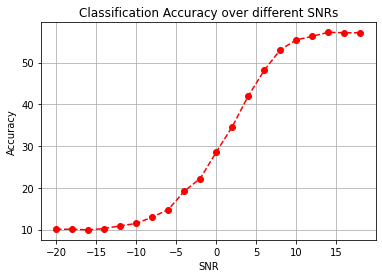

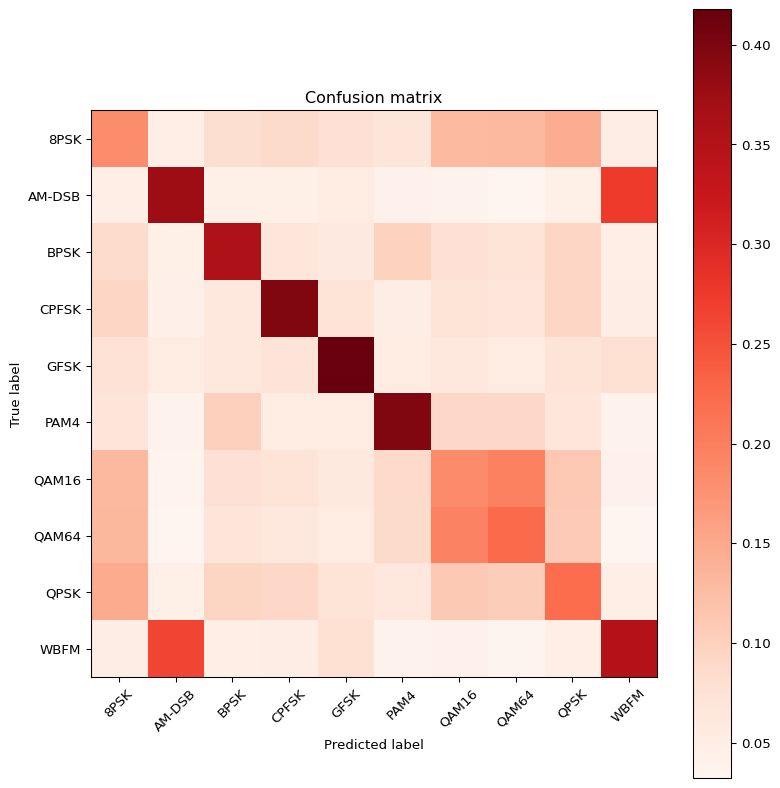

In [ ]:
plot_results(y_pred_dtcModel, y_test, snr_test)
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_dtcModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [14]:
print_results(y_pred_dtcModel, y_test, snr_test)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.07,10.11,9.93,10.25,10.9,11.47,12.99,14.79,19.17,22.25,28.55,34.66,42.02,48.17,53.09,55.45,56.3,57.28,57.14,57.18


#Model Random Forest

In [ ]:
X_train = data[train_examples]
X_test = data[test_examples]

#labal as 1 at the spacific class which get from first column of label
y_train = LB().fit_transform(labels[train_examples][:,0])
y_test = LB().fit_transform(labels[test_examples][:,0])

#labal as SNR which get from second column of label
snr_train = labels[train_examples][:,1].astype(int)
snr_test = labels[test_examples][:,1].astype(int)

print(y_train.shape)
print(snr_train.shape)


In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs = 1)
nsamples, nx, ny = data[train_examples].shape
#d2_train_dataset = data[train_examples].reshape((nsamples,nx*ny))
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(data[train_examples].reshape((nsamples,nx*ny)), LB().fit_transform(labels[train_examples][:,0]))

nsamples, nx, ny = data[test_examples].shape
#d2_test_dataset = data[test_examples].reshape((nsamples,nx*ny))
y_pred_mrfModel = clf.predict(data[test_examples].reshape((nsamples,nx*ny)))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel))
print(confusion_matrix(LB().fit_transform(labels[test_examples][:,0]).argmax(axis=1), y_pred_mrfModel.argmax(axis=1)))
print(metrics.classification_report(LB().fit_transform(labels[test_examples][:,0]), y_pred_mrfModel,target_names=['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'] ))

#Evaluation

In [ ]:
plot_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,data[test_examples].shape[0]):
    # j is first value in list
    j = list(LB().fit_transform(labels[test_examples][:,0])[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(y_pred_mrfModel[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

In [ ]:
print_results(y_pred_mrfModel, LB().fit_transform(labels[test_examples][:,0]), labels[test_examples][:,1].astype(int))